## Segmentation of User Interaction Logs using Time Series Methods

A demo case used for the idea paper at BPM Technology Forum 2025

#### Execution environment of experiments in the paper:
Windows 11, 16 GB Ram, Python 3.12

#### Execution times for experiments:

Experiment A) Context Parameter Selection: ~5 Min per selected parameter

Experiment B) Window Size Impact: 80-100 Minutes

Experiment C) Motif Count Impact: Mainly the Matrix Profil Calculation, ~5 Min

Experiment D) Cluster Purity: 3-5 Minutes per Matrix Profil Calculation

In [1]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config
import ast

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import util.util
import matplotlib as plt
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data Gathering

Read the Logs that should be discovered from the folder "Leno".

Adjust the file names according to your needs:
1. SRRT_Plus => The file that contains the sequentially ordered traces
2. SRRT_Parallel => The file that contains the alternating traces

In [2]:
file_path = 'Leno/'
# The following two files were used in the Experiment in the paper
srrt_plus_filename = "experiment_extended_SR_RT_plus.csv"
srrt_parallel_filename = "experiment_extended_SR_RT_parallel.csv"

text_encoding_method = "utf-8"
seperator ='' ";"

srrt_plus_log = pd.read_csv(file_path + srrt_plus_filename, encoding=text_encoding_method, sep=seperator)
srrt_parallel_log = pd.read_csv(file_path + srrt_parallel_filename, encoding=text_encoding_method, sep=seperator)

## 1. Single Log Execution

### 1.A. Single Word2Vec Discovery

Single Sentence Word2Vec encoding

Discovered Motif Indexes: [394, 537, 680, 823, 1537, 1964, 2513, 2654, 2966, 3964]
Ground Truth:[   0   54   80  166  223  309  364  450  507  593  650  736  793  879
  934 1021 1138 1166 1221 1307 1364 1450 1507 1593 1648 1734 1791 1877
 1934 2020 2078 2164 2221 2310 2365 2451 2569 2597 2710 2740 2793 2879
 2936 3022 3080 3166 3223 3309 3366 3452 3507 3593 3648 3734 3791 3877
 3934 4020 4077 4163 4220 4308 4366 4452 4509 4595 4652 4738 4795 4881
 4938 5024 5082 5168 5225 5311 5368 5454 5511 5597 5654 5740 5797 5883
 5940 6027 6084 6170 6227 6313 6370 6456 6513 6600 6657 6743 6800 6886
 6943 7029]
Precision: 1.0
Recall: 0.1
F1-Score: 0.18181818181818182


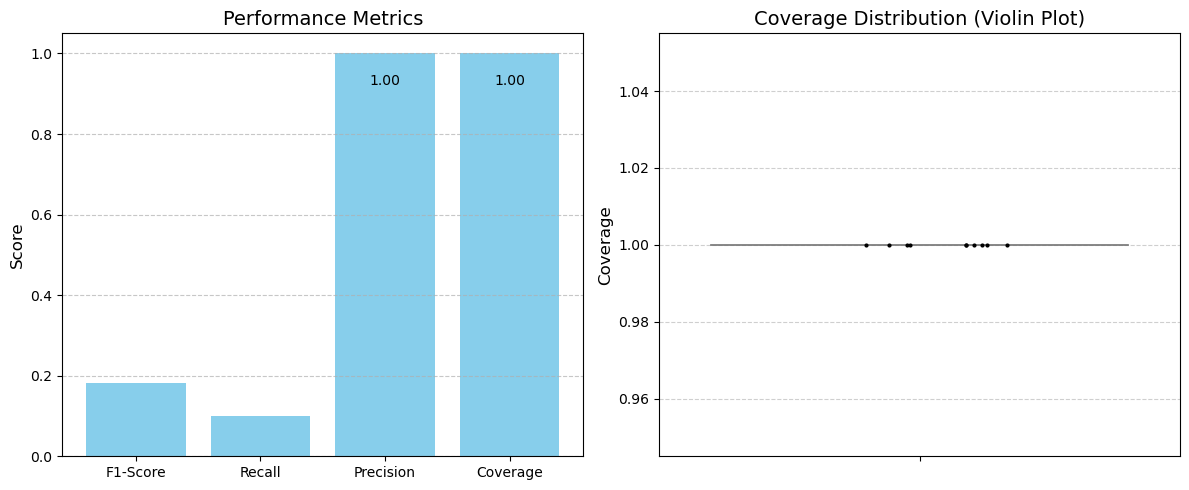

In [4]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

size = 30
motifs_to_discover = 10
threshold = 0.0

columns_to_use = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

# ---- Single Log execution ----
case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=columns_to_use, vector_size=50)
motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,motifs_to_discover)
print(f"Discovered Motif Indexes: {sorted(motif_indices[0])}")

print(f"Ground Truth:{np.sort(groundTruth)}")

# ---- Measuring Method: Half the Window Size ----
# insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(motif_indices[0]), (size/2))
original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
mean_coverage = 0

if 'coverage' in overlapDF.columns:
    mean_coverage = overlapDF.loc[:, "coverage"].mean()

ground_truth_sum = len(groundTruth)
true_positives = len(original_inserts_indexes)
false_positives = motifs_to_discover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Bar Chart ---
metrics = ['F1-Score', 'Recall', 'Precision', 'Coverage']
values = [f1_score, recall, precision, mean_coverage]
axes[0].bar(metrics, values, color='skyblue')
axes[0].set_ylim(0, 1.05)  # Slightly higher to leave space for label

axes[0].set_title('Performance Metrics', fontsize=14)
axes[0].set_ylabel('Score', fontsize=12)

for i, v in enumerate(values):
    if v > 0.5:
        offset = -0.05 if v > 0.98 else 0.02  # Push label down if bar is too high
        axes[0].text(i, v + offset, f"{v:.2f}", ha='center', va='top' if offset < 0 else 'bottom', fontsize=10)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Violin Plot with Points for IoU ---
sns.violinplot(y=overlapDF["coverage"], ax=axes[1], inner=None, color='lightblue')
sns.stripplot(y=overlapDF["coverage"], ax=axes[1], color='black', size=3, jitter=0.2)
axes[1].set_title("Coverage Distribution (Violin Plot)", fontsize=14)
axes[1].set_ylabel("Coverage", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 1.B. Clustering of discovered Routines

DBSCAN Clustering of the identified routines from the data of the previous step. So executed 1.A. first.

c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


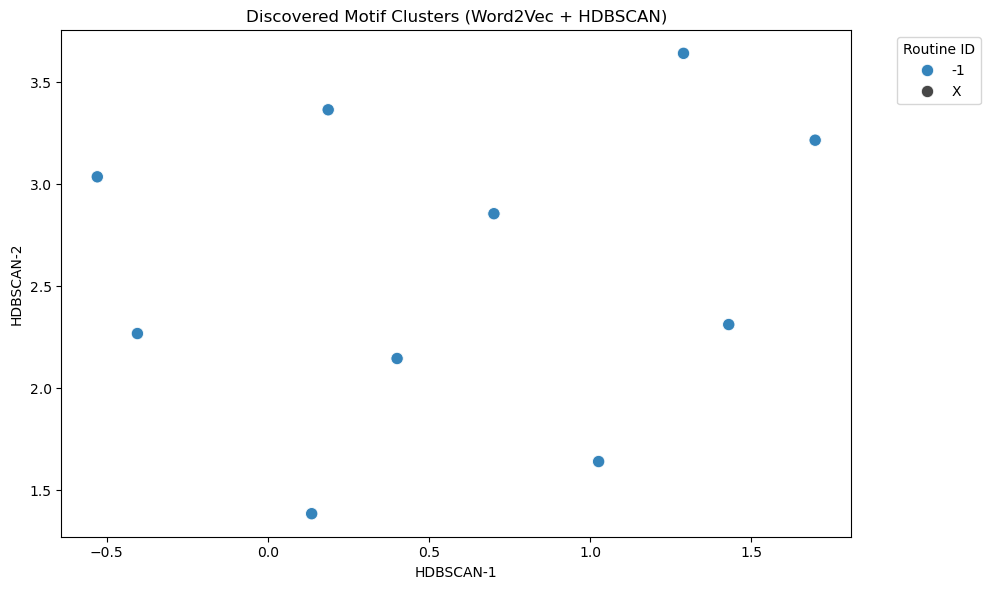


Routine -1 (total motifs: 10):
  Length 62: 10 motifs (100.0%)

Routine -1 (total motifs: 10):
Lengths in [26–36]: 0 motifs (0.0%)
Lengths in [56–66]: 10 motifs (100.0%)


In [ ]:
# ---- Example Usage ----
# Date: ui_log = your full DataFrame with word2vec columns
#          motif_starts = list of discovered motif start indices
#          window_size = length of each motif

df_clusters = util.util.cluster_motifs_with_word2vec(ui_log_encoded_w2v, overlapDF["discoveredMotif"].tolist(), size)
util.util.plot_motif_clusters(df_clusters)

# Create a mapping from start_index to length
length_map = dict(zip(overlapDF["discoveredMotif"], overlapDF["groundTruthLength"]))

# Add 'length' to each motif in df_clusters
df_clusters["length"] = df_clusters["start_index"].map(length_map)

# ---- Print cluster metrics ----
# Group and count motif lengths per cluster
cluster_length_counts = df_clusters.groupby("routine_id")["length"].value_counts()

# Normalize to get total motifs per cluster
cluster_totals = df_clusters.groupby("routine_id")["length"].count()

# Print with percentages
for routine_id, group in cluster_length_counts.groupby(level=0):
    total = cluster_totals[routine_id]
    print(f"\nRoutine {routine_id} (total motifs: {total}):")
    for (rid, length), count in group.items():
        percentage = (count / total) * 100
        print(f"  Length {length}: {count} motifs ({percentage:.1f}%)")

# SR and RT boundaries from Leno Paper to define the cluster range
short_range = (26, 36)  # 31 ± 5
long_range = (56, 66)   # 61 ± 5

# Group by cluster
clustered = df_clusters.groupby("routine_id")["length"]

# Compute and print
for routine_id, lengths in clustered:
    total = len(lengths)
    count_short = sum(lengths.between(*short_range))
    count_long = sum(lengths.between(*long_range))
    
    percent_short = (count_short / total) * 100 if total > 0 else 0
    percent_long = (count_long / total) * 100 if total > 0 else 0
    
    print(f"\nRoutine {routine_id} (total motifs: {total}):")
    print(f"Lengths in [26–36]: {count_short} motifs ({percent_short:.1f}%)")
    print(f"Lengths in [56–66]: {count_long} motifs ({percent_long:.1f}%)")

# ---- Save the clusters ----
# df_clusters.to_csv(f'ExperimentResult/ClusteredMotifs_{log_to_discover_name}_{timestamp}.csv', index=False)

## 2. Automated Experiment for multiple window sizes

### Word2Vec Encoding Based

Experiment A) Impact of column selection on discovery result (EX1)

Experiment B) Impact of window size on discovery result (EX2)

Experiment C) Impact of discovered motifs on discovery result (EX3)

#### A) Fixed Window Size, Fixed Motif to Discover, Different Context Columns

w_s = 30, t=10, Context Columns fluctuating

In the paper referred to as Step 1/ Experiment 1

Processing Columns: ['targetApp']
[(450, 32), (593, 32), (1166, 30), (1734, 32), (2164, 32), (3309, 32), (3593, 30)]
Processing Columns: ['targetApp', 'eventType']
[(80, 61), (223, 61), (364, 61), (507, 61), (650, 61), (793, 61), (1021, 92), (1221, 61), (1364, 61), (1507, 61)]
Processing Columns: ['targetApp', 'eventType', 'url']
[(80, 61), (223, 61), (364, 61), (507, 61), (650, 61), (793, 61), (1021, 92), (1221, 61), (1364, 61), (1507, 61)]
Processing Columns: ['targetApp', 'eventType', 'url', 'target.workbookName']
[(80, 61), (364, 61), (934, 62), (1791, 61), (3223, 61), (3507, 61), (5511, 61), (6084, 61), (6227, 61), (6657, 61)]
Processing Columns: ['targetApp', 'eventType', 'url', 'target.workbookName', 'target.sheetName']
[(80, 61), (223, 61), (364, 61), (507, 61), (650, 61), (793, 61), (1021, 92), (1221, 61), (1364, 61), (1507, 61)]
Processing Columns: ['targetApp', 'eventType', 'url', 'target.workbookName', 'target.sheetName', 'target.id']
[(507, 61), (650, 61), (1021, 92), (164

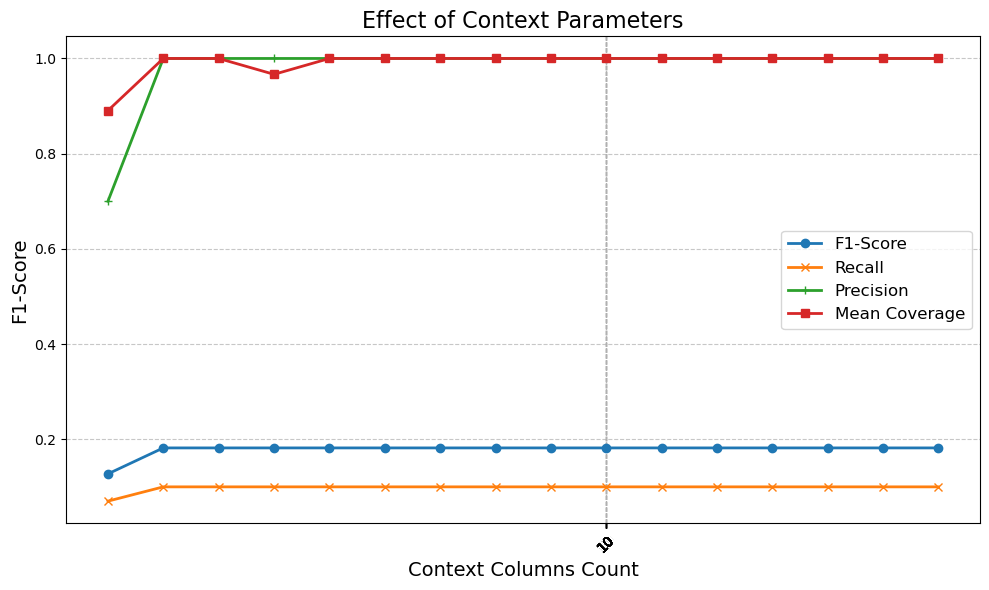

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

# All Context Columns
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
NumberOfMotifsToDiscover = 10
threshold = 0.8

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])


case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----

discovery_repeat = False
start = 1
for i in range(start, len(ContextColumns) + 1):
    contextColumnSelection = ContextColumns[:i]
    ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=contextColumnSelection, vector_size=50)

    print(f"Processing Columns: {contextColumnSelection}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])
    
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0

        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': sorted(set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None))),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover,
            'context_columns': contextColumnSelection,
            'context_columns_count': i
        })
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    results_df.to_csv(f'ExperimentResult/ColumnScore-EX1_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['context_columns_count'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['context_columns_count'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['context_columns_count'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['context_columns_count'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Context Parameters', fontsize=16)
plt.xlabel('Context Columns Count', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['motif_count'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX1-ColumnScore_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')

### B) Fixed Number of motifs with changing window size
Fixed t=10, w_S = range(26,68)

In the paper referred to as Step 2 / Experiment 2

Processing size: 26
Processing size: 27
Processing size: 28
Processing size: 29
Processing size: 30
Processing size: 31
Processing size: 32
Processing size: 33
Processing size: 34
Processing size: 35
Processing size: 36
Processing size: 37
Processing size: 38
Processing size: 39
Processing size: 40
Processing size: 41
Processing size: 42
Processing size: 43
Processing size: 44
Processing size: 45
Processing size: 46
Processing size: 47
Processing size: 48
Processing size: 49
Processing size: 50
Processing size: 51
Processing size: 52
Processing size: 53
Processing size: 54
Processing size: 55
Processing size: 56
Processing size: 57
Processing size: 58
Processing size: 59
Processing size: 60
Processing size: 61
Processing size: 62
Processing size: 63
Processing size: 64
Processing size: 65
Processing size: 66
Processing size: 67
Processing size: 68


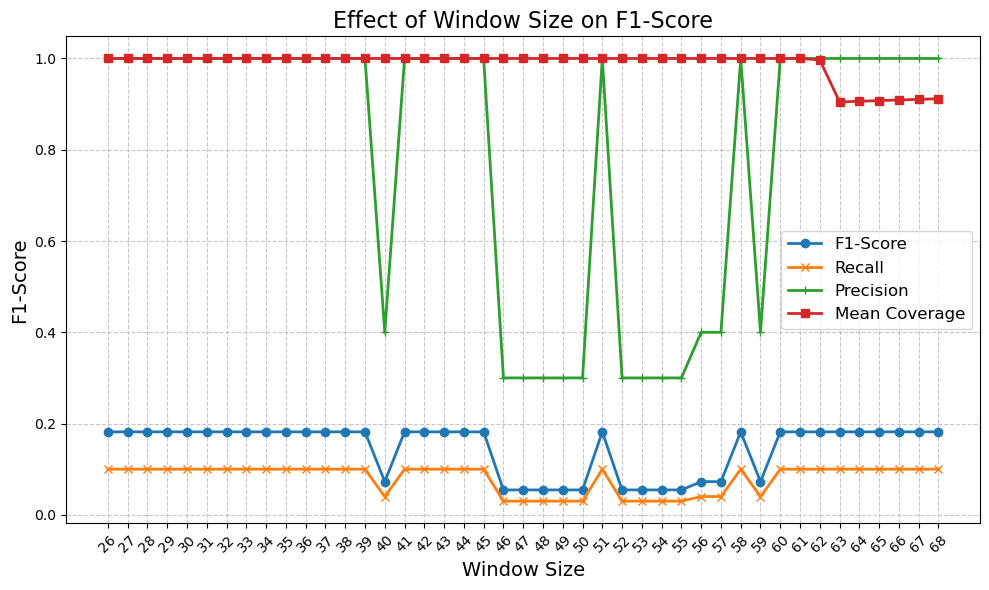

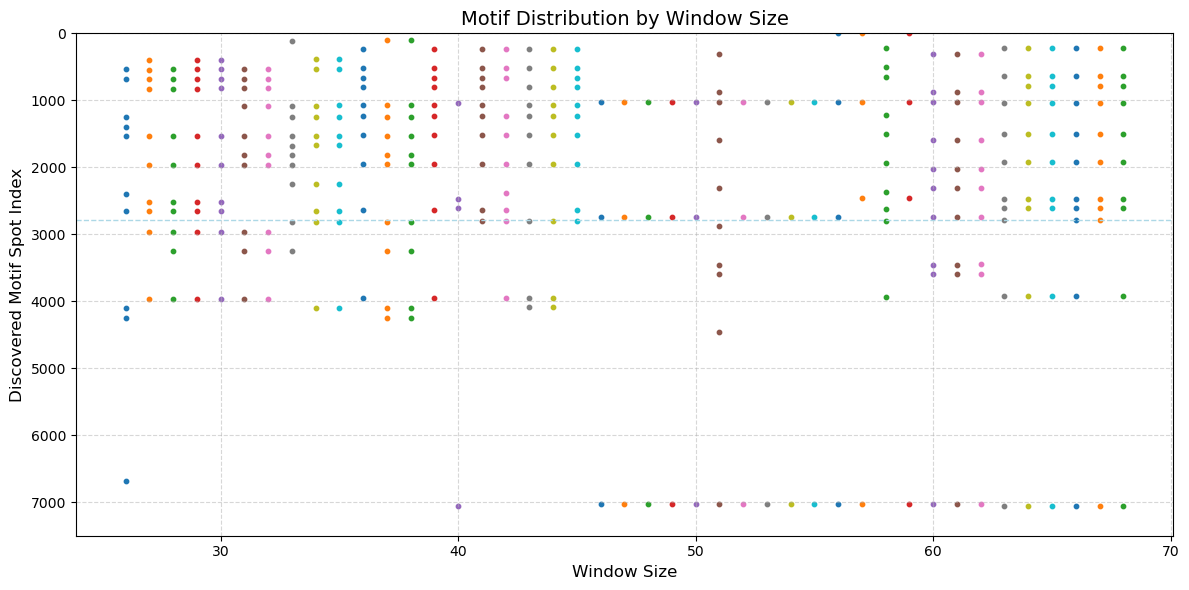

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

NumberOfMotifsToDiscover = 10
threshold = 0.8

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

# ---- Generate ground truth ----
case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
size = 26
while size <= 68:
    print(f"Processing size: {size}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])

    original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
    mean_coverage = 0
    
    if 'coverage' in overlapDF.columns:
        mean_coverage = overlapDF.loc[:, "coverage"].mean()
    else:
        mean_coverage = 0

    true_positives = len(original_inserts_indexes)
    false_positives = NumberOfMotifsToDiscover - true_positives
    false_negatives = ground_truth_sum - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Filter the length of the discovered motifs
    filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
    motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

    # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
    results.append({
        'window_size': size,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_coverage': mean_coverage,
        'discovered_indexes': set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None)),
        'discovered_motif_spots': set(discovered_motif_spots),
        'motif_count': NumberOfMotifsToDiscover
    })
    size += 1

# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    results_df.to_csv(f'ExperimentResult/EX2-windowSize_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['window_size'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['window_size'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['window_size'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX2-windowSize_{log_to_discover_name}_plot-MetricResults_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# ---- Motif Distribution Plot ----
plt.figure(figsize=(12, 6))

# Loop over each window size
for ws in sorted(results_df['window_size'].unique()):
    subset = results_df[results_df['window_size'] == ws]
    # Convert sets to sorted lists and flatten
    all_spots = []
    for entry in subset['discovered_motif_spots']:
        if isinstance(entry, set):
            all_spots.extend(sorted(entry))
        elif isinstance(entry, list):
            all_spots.extend(entry)
    x_vals = [ws] * len(all_spots)
    plt.scatter(x_vals, all_spots, label=f'Window Size {ws}', s=10)

plt.ylim(7500, 0)
plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Discovered Motif Spot Index", fontsize=12)
plt.title("Motif Distribution by Window Size", fontsize=14)
if log_to_discover_name == "SRRT_Parallel":
    plt.axhline(y=2789, color='lightblue', linestyle='--', linewidth=1, label='Start of RT Traces') # Only works for SRRT_Joint
plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(title="Window Sizes", fontsize=9)
plt.tight_layout()
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX2-windowSize_{log_to_discover_name}_plot-MotifDistribution_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

### C) Fixed Window Size, Flexible Number of motifs t

w_s = 30 and t=[5,10,20,30,40,50,60,70,80,90,100]

In the paper referred to as Step 3 / Experiment 3.

Processing Motif Count: 5
Processing Motif Count: 10
Processing Motif Count: 20
Processing Motif Count: 30
Processing Motif Count: 40
Processing Motif Count: 50
Processing Motif Count: 60
Processing Motif Count: 70
Processing Motif Count: 80
Processing Motif Count: 90
Processing Motif Count: 100


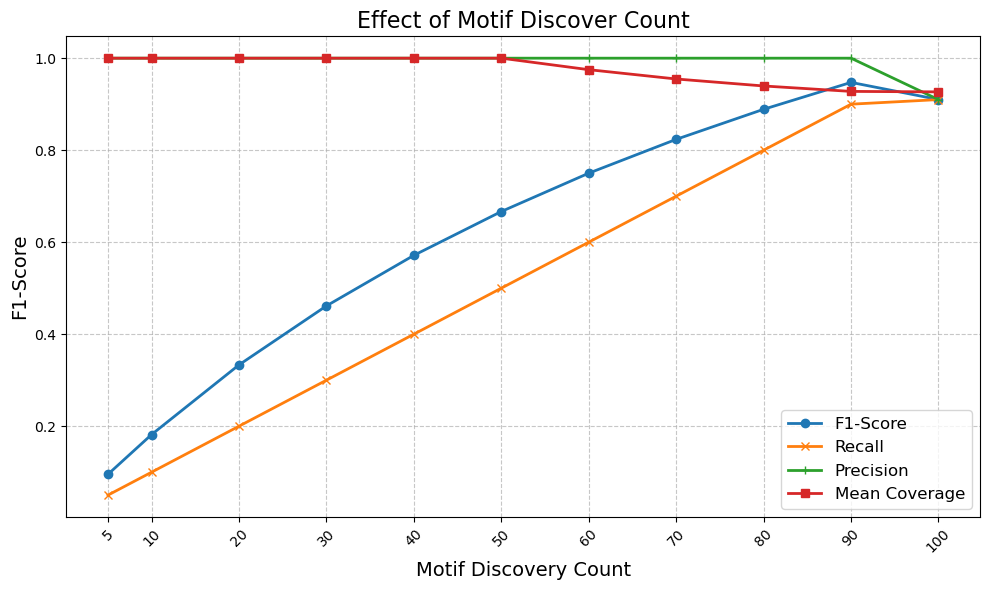

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
threshold = 0.8

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
discoverable_motifs = [10,20,30,40,50,60,70,80,90,100]
discovery_repeat = False

# ---- Calculate the matrix profil once ----
# This is a performance optimization to avoid recalculating it in each loop
time_series_data, p_mult_matrix_profil, i_multi_motif_indexes = util.util.compute_matrix_profile(ui_log_encoded_w2v, size=size)

# ---- Loop through the discoverable motifs ----
for NumberOfMotifsToDiscover in discoverable_motifs:
    print(f"Processing Motif Count: {NumberOfMotifsToDiscover}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.extract_motifs(time_series_data, p_mult_matrix_profil, i_multi_motif_indexes, NumberOfMotifsToDiscover)   

    discovered_set = set(motif_indices[0])
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0
        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        # filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        # motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None)),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover
        })
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    results_df.to_csv(f'ExperimentResult/NoOfDiscovery-EX3_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['motif_count'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['motif_count'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['motif_count'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['motif_count'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Motif Discover Count', fontsize=16)
plt.xlabel('Motif Discovery Count', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['motif_count'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX3-NoOfDiscovery_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')

### D) Cluster Purity Evaluation

Measure how well the identified motifs result in clusters that indicate if these then are "pure" for further processing in the RPM pipeline.

In the paper Step 4 / Experiment 4.

Window Size: 25, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 1.0


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 25, Motif Count: 30, Clusters: 1, Total Motifs: 30, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 25, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 25, Motif Count: 70, Clusters: 2, Total Motifs: 70, Cluster Purity: 0.929


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 25, Motif Count: 100, Clusters: 2, Total Motifs: 96, Cluster Purity: 0.865


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 30, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 1.0


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 30, Motif Count: 30, Clusters: 1, Total Motifs: 30, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 30, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 30, Motif Count: 70, Clusters: 2, Total Motifs: 70, Cluster Purity: 0.929


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 30, Motif Count: 100, Clusters: 2, Total Motifs: 96, Cluster Purity: 0.906


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 40, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 1.0


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 40, Motif Count: 30, Clusters: 1, Total Motifs: 30, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 40, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 40, Motif Count: 70, Clusters: 3, Total Motifs: 70, Cluster Purity: 0.957


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 40, Motif Count: 100, Clusters: 3, Total Motifs: 96, Cluster Purity: 0.917


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 50, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 1.0


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 50, Motif Count: 30, Clusters: 1, Total Motifs: 30, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 50, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 50, Motif Count: 70, Clusters: 2, Total Motifs: 70, Cluster Purity: 0.929


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 50, Motif Count: 100, Clusters: 2, Total Motifs: 93, Cluster Purity: 0.925


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 60, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 1.0


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
c:\Users\tomho\OneDrive\Documents\VSCode\TimeSeriesInRPM\util\util.py:1017: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))
C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 60, Motif Count: 30, Clusters: 1, Total Motifs: 30, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 60, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 60, Motif Count: 70, Clusters: 2, Total Motifs: 54, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 60, Motif Count: 100, Clusters: 2, Total Motifs: 54, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 65, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 1.0


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 65, Motif Count: 30, Clusters: 1, Total Motifs: 30, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 65, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 1.0


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 65, Motif Count: 70, Clusters: 1, Total Motifs: 51, Cluster Purity: 0.98


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


Window Size: 65, Motif Count: 100, Clusters: 1, Total Motifs: 51, Cluster Purity: 0.98


C:\Users\tomho\AppData\Local\Temp\ipykernel_112\4291651107.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show manually in Jupyter or script


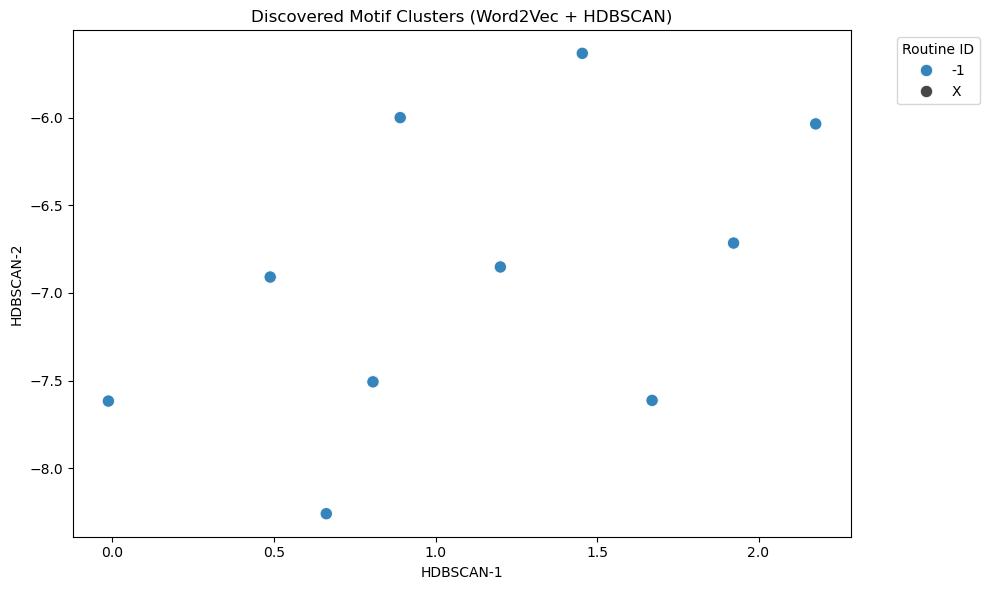

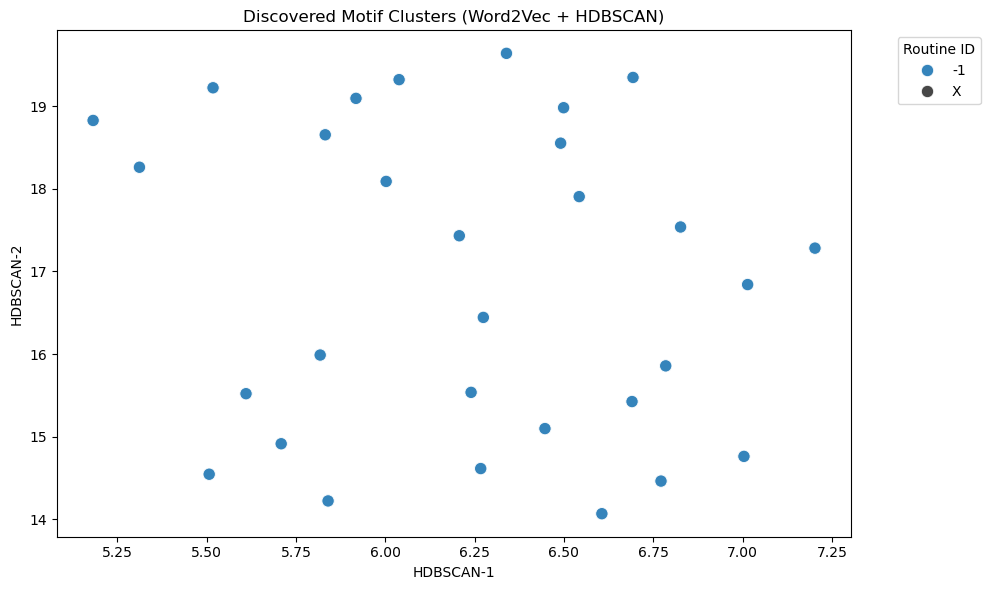

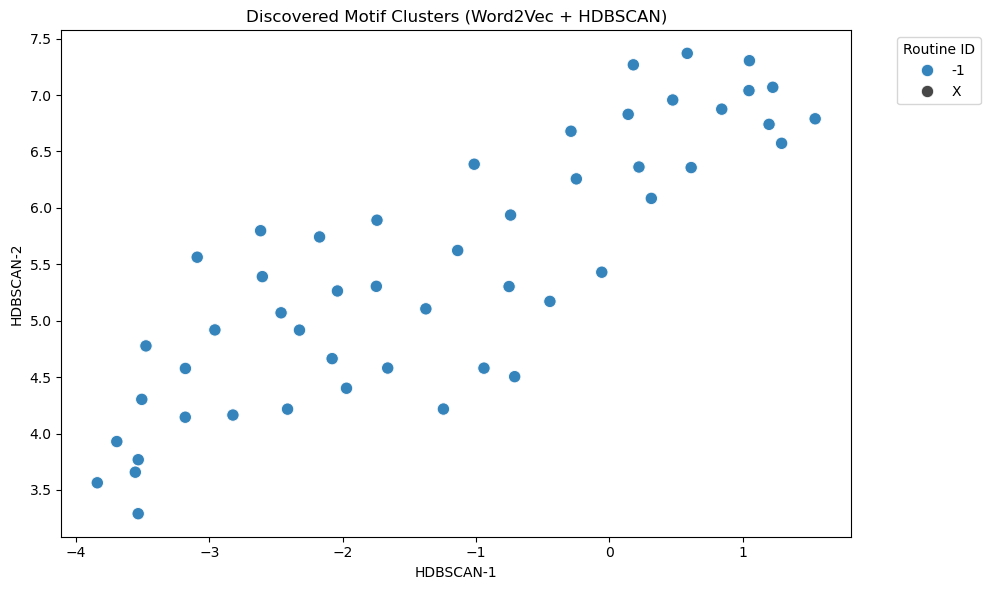

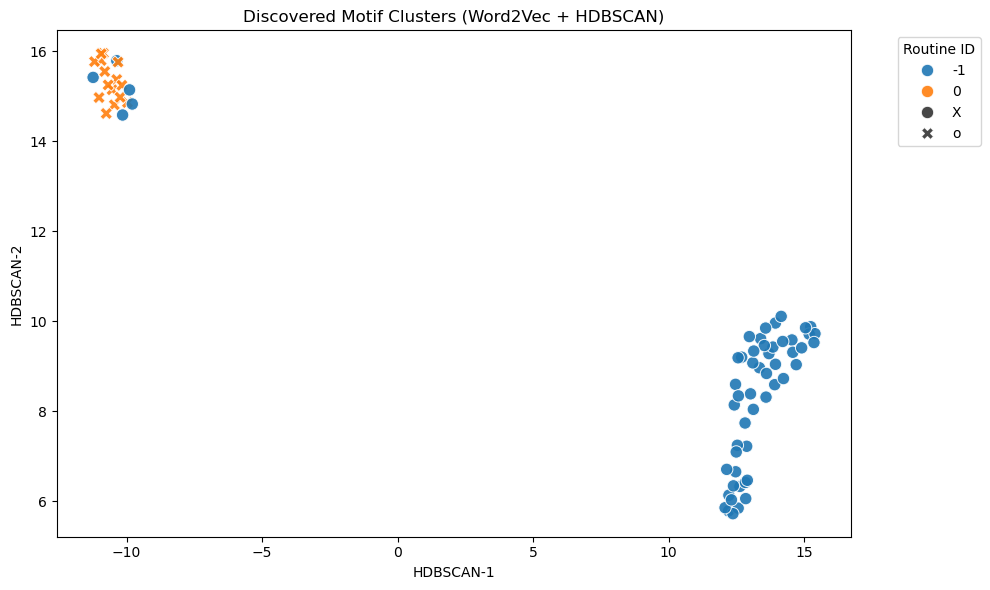

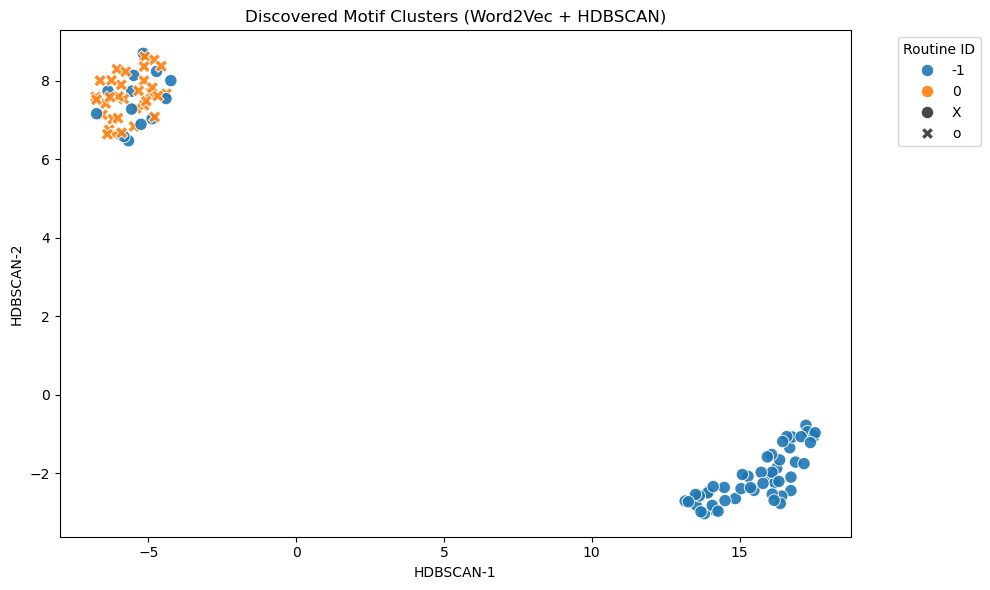

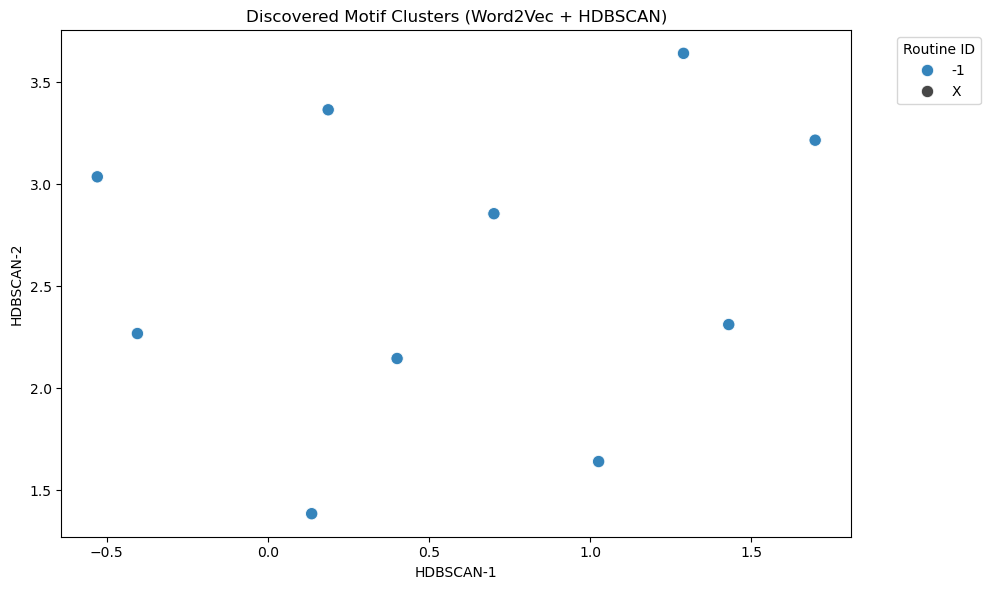

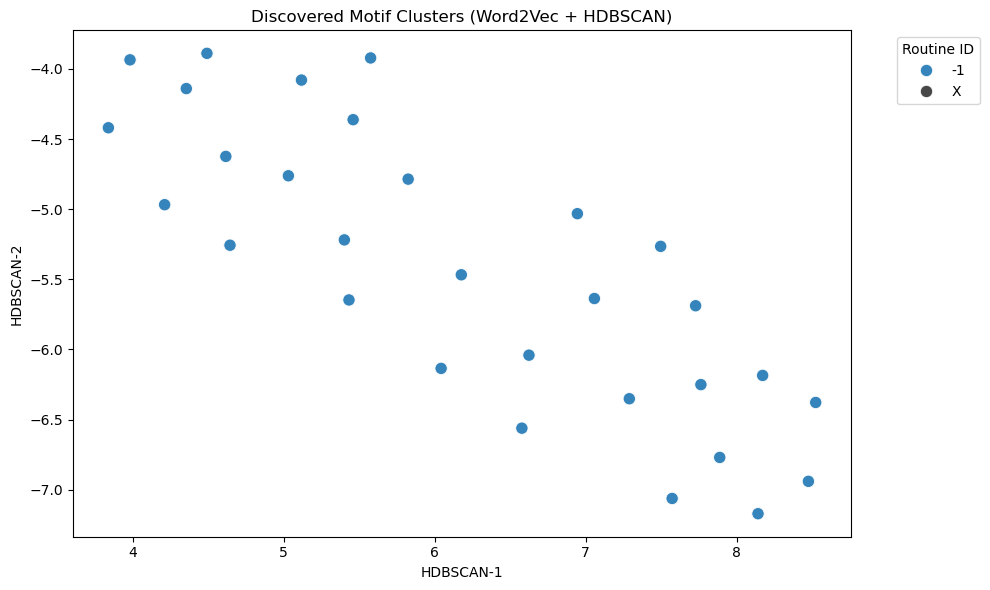

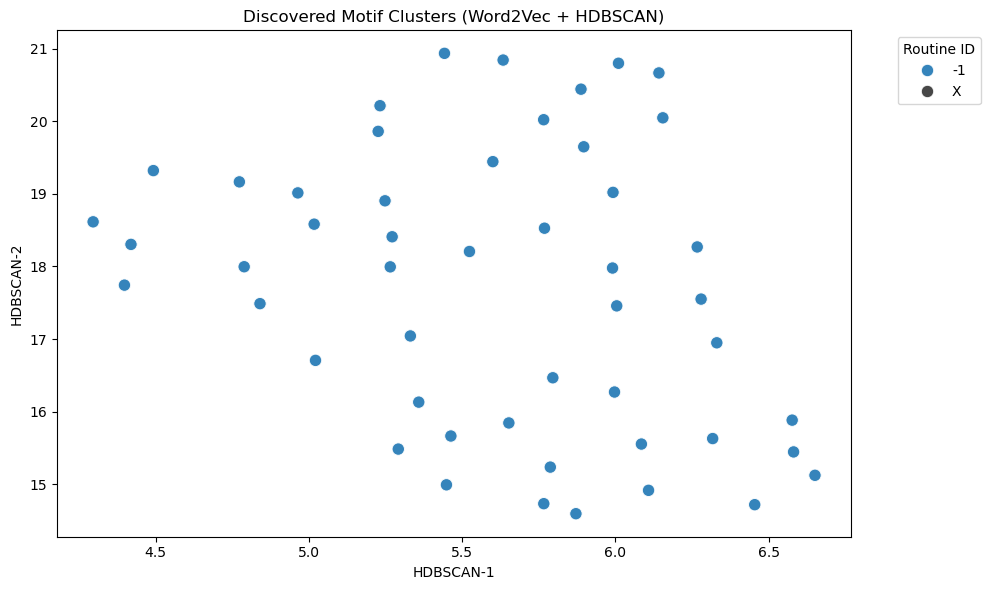

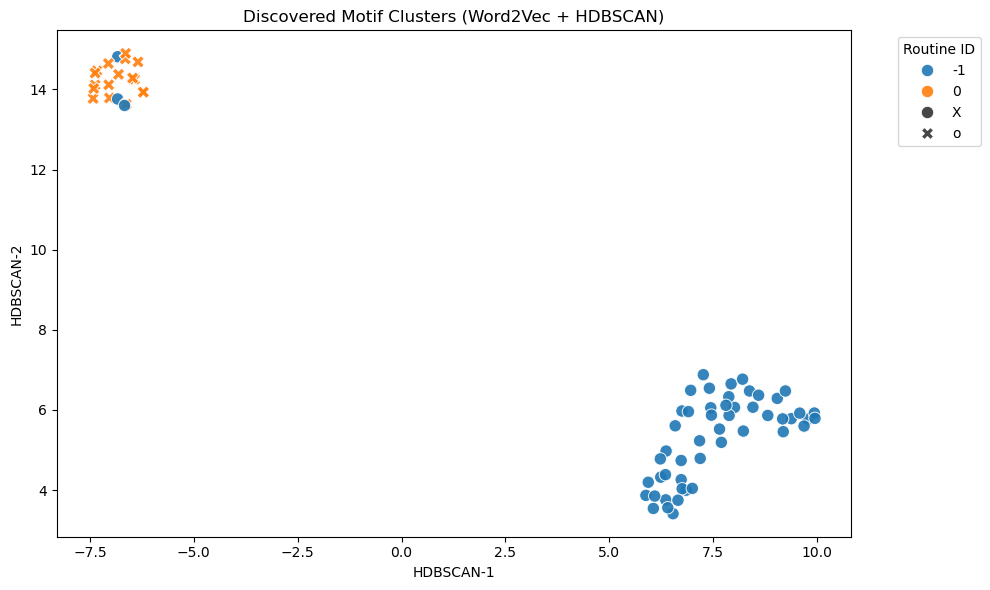

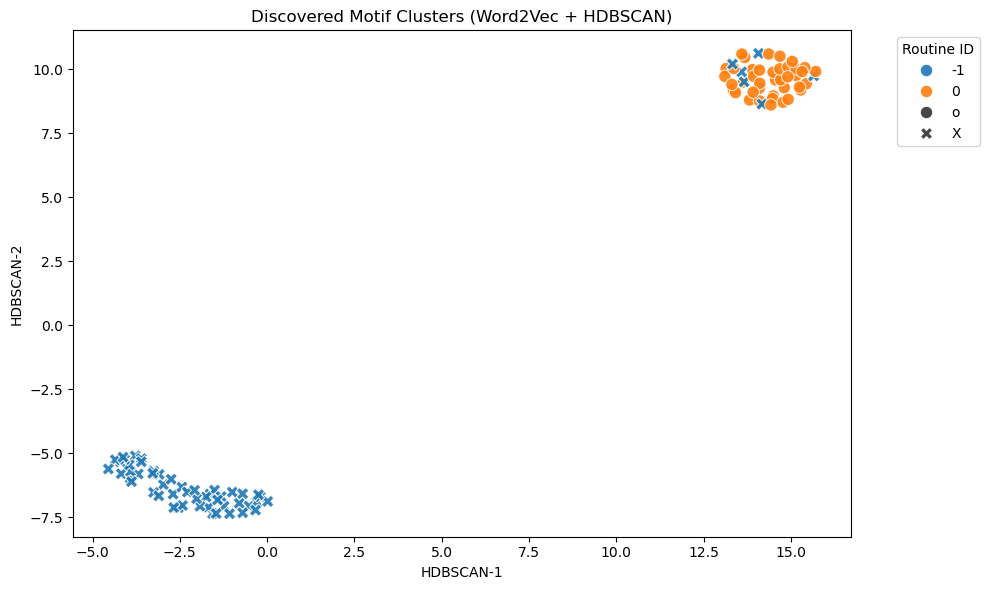

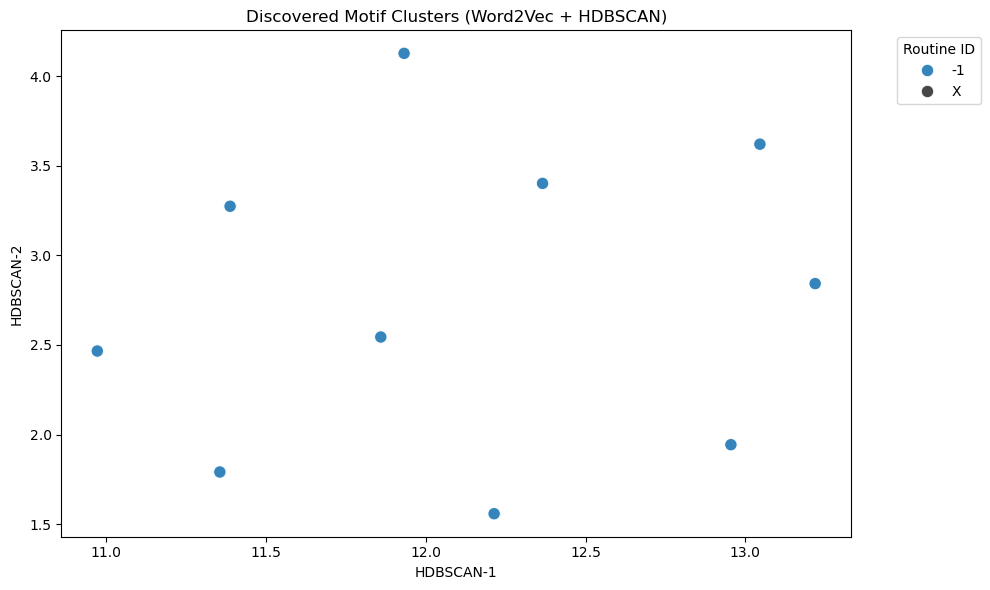

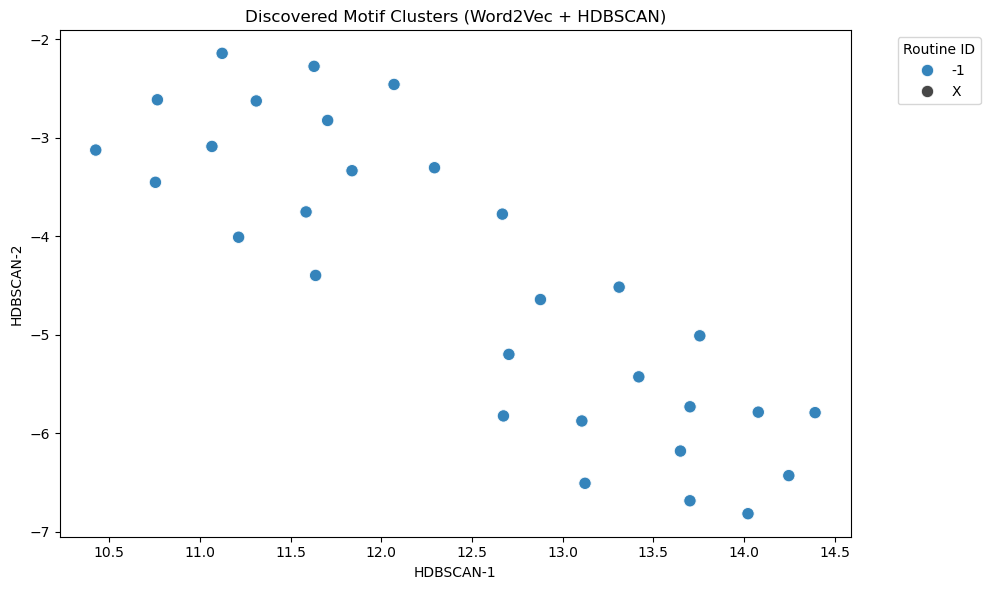

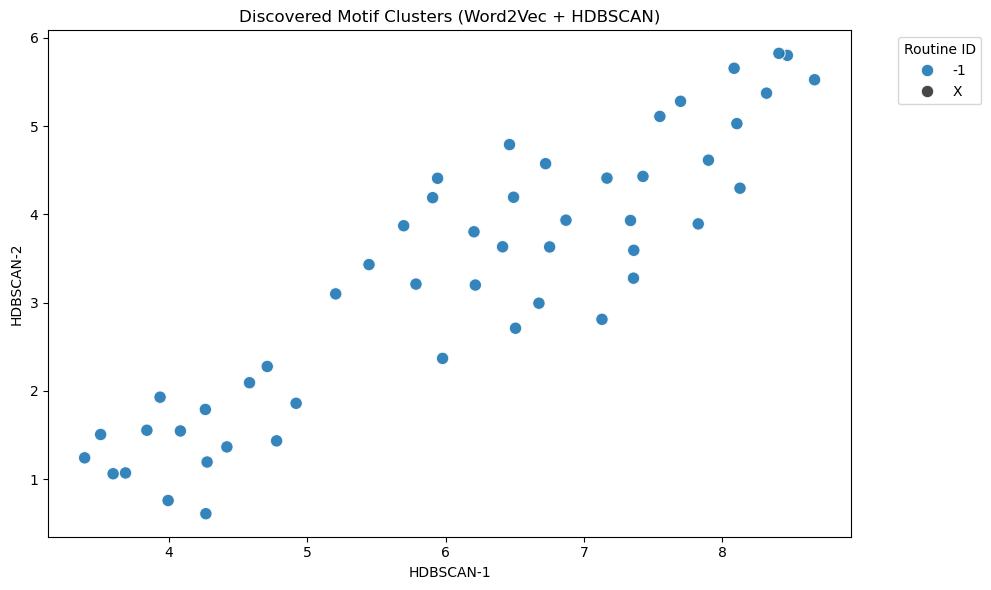

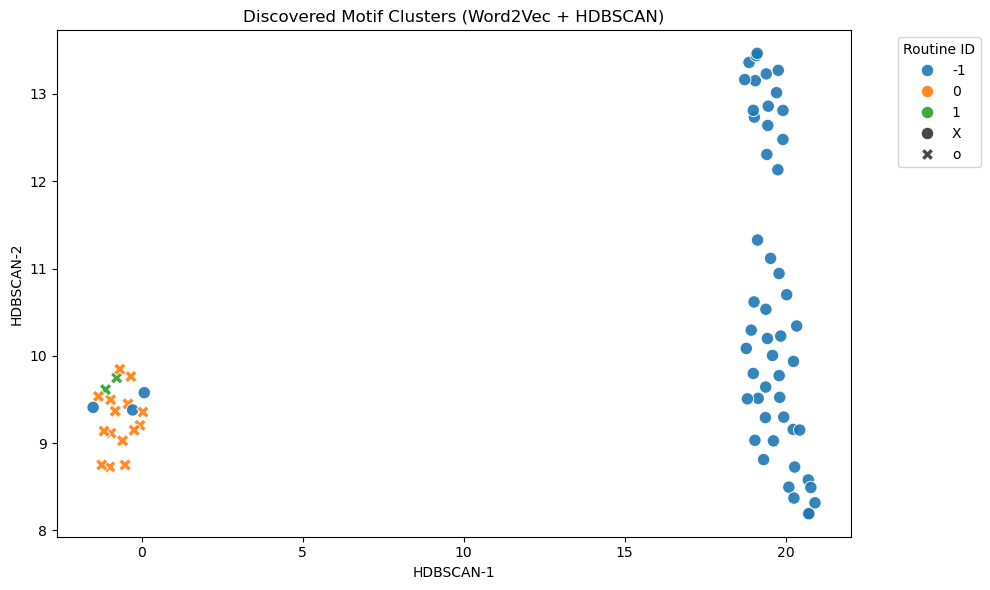

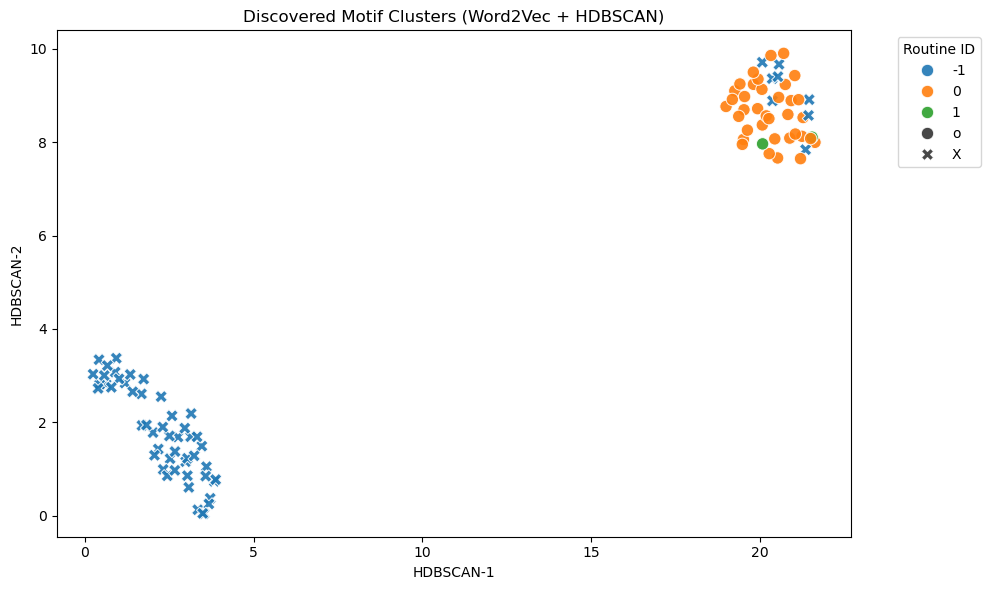

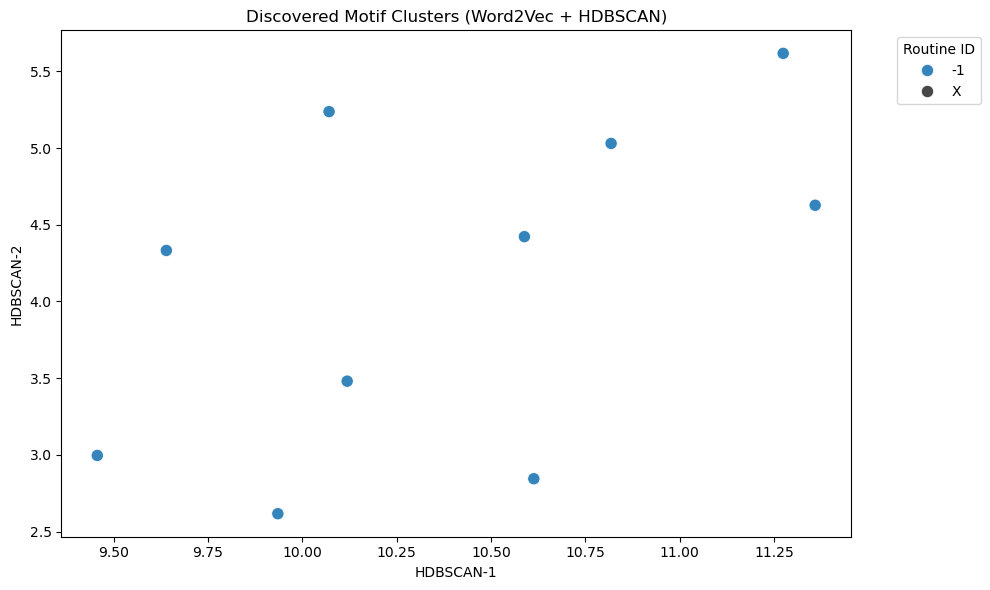

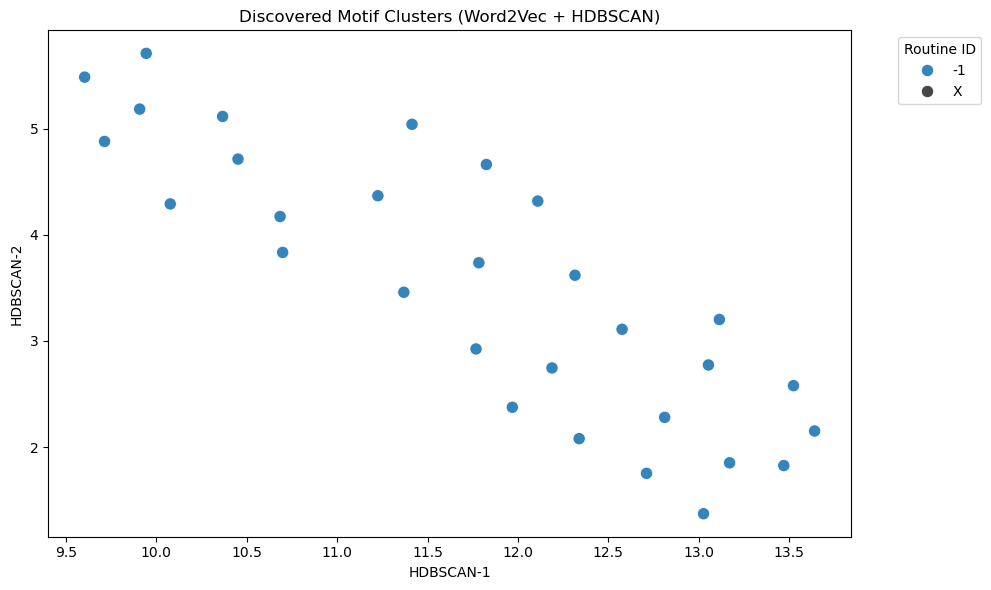

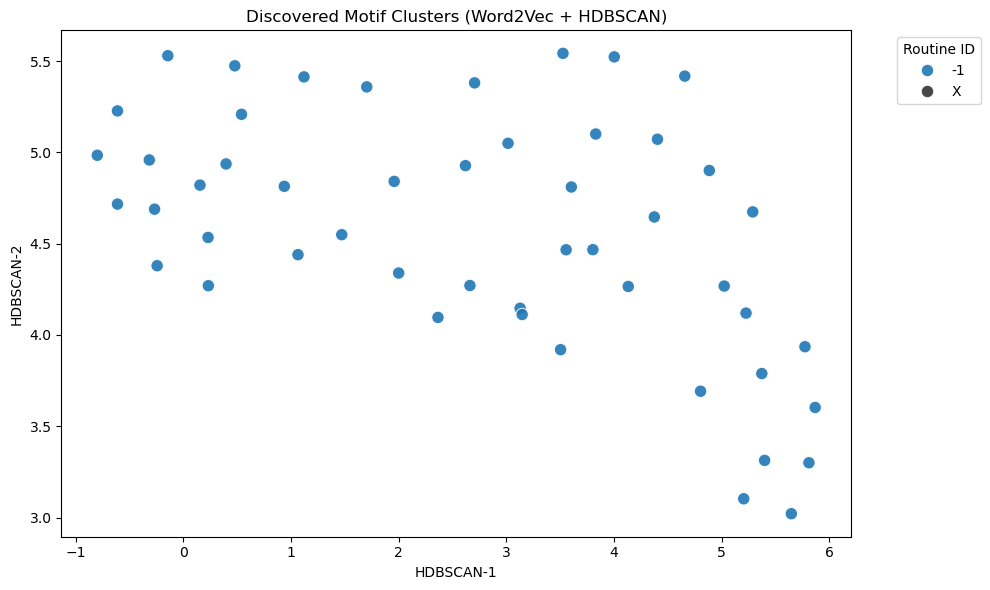

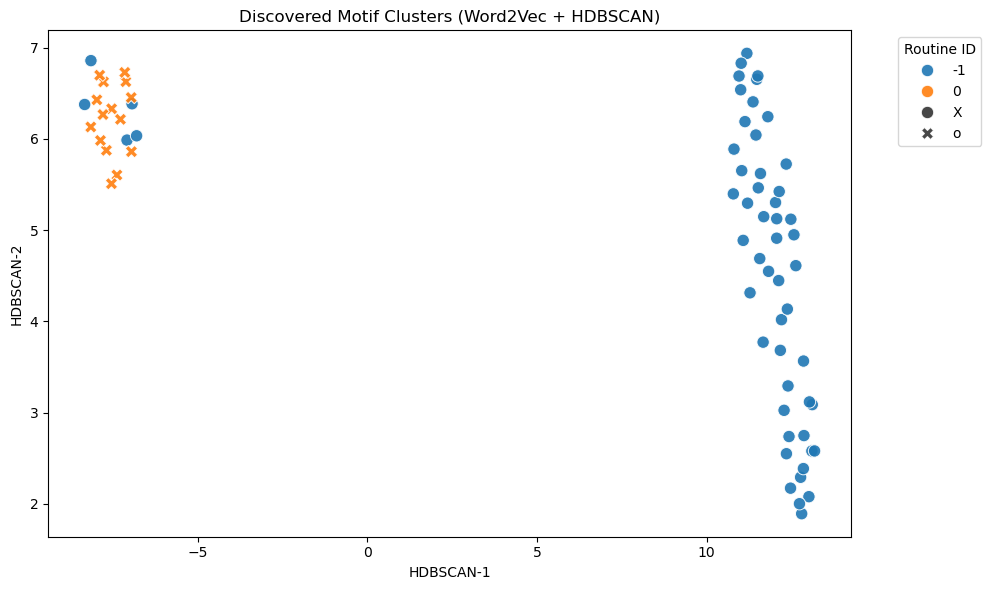

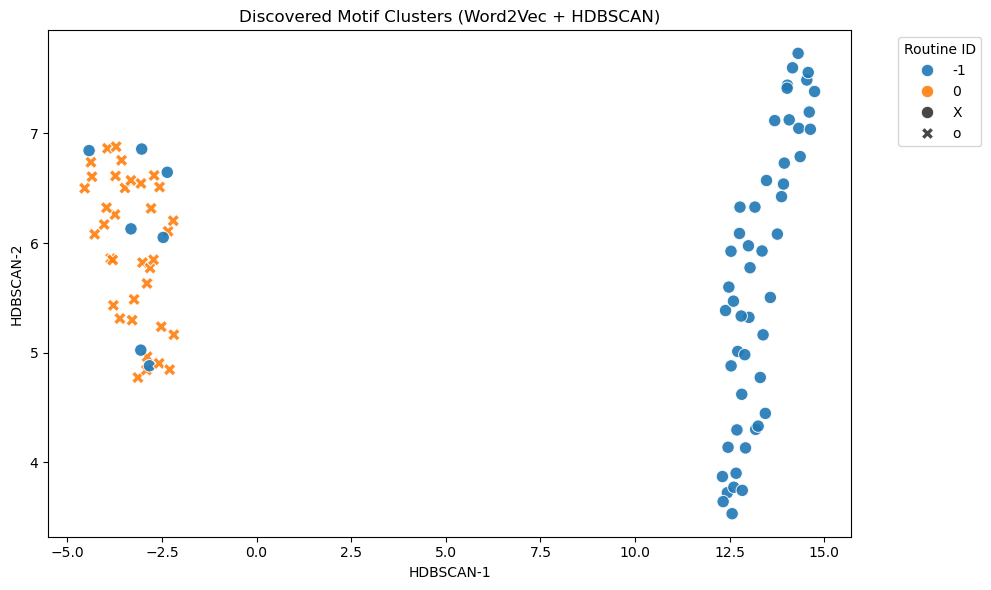

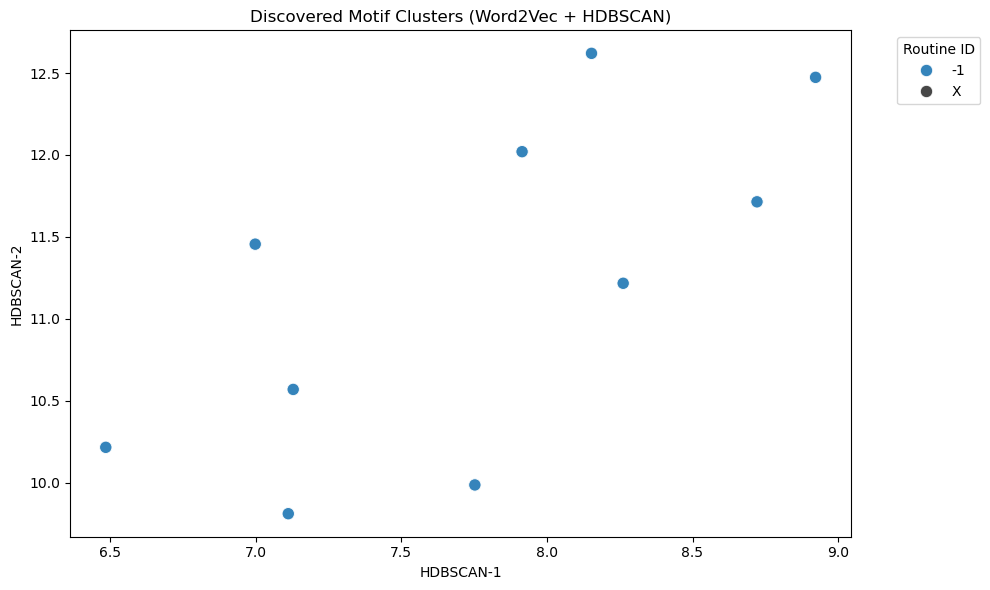

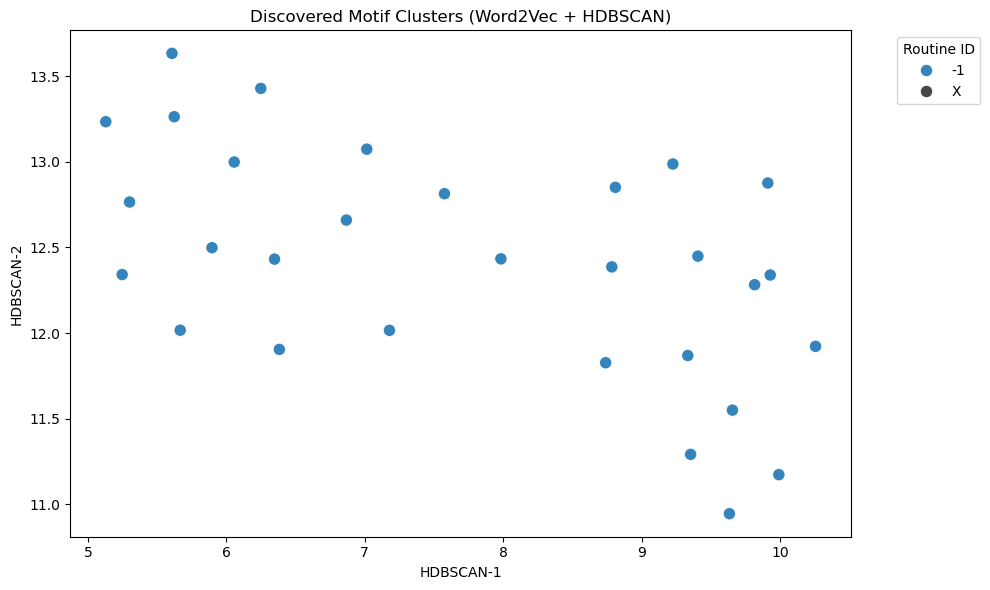

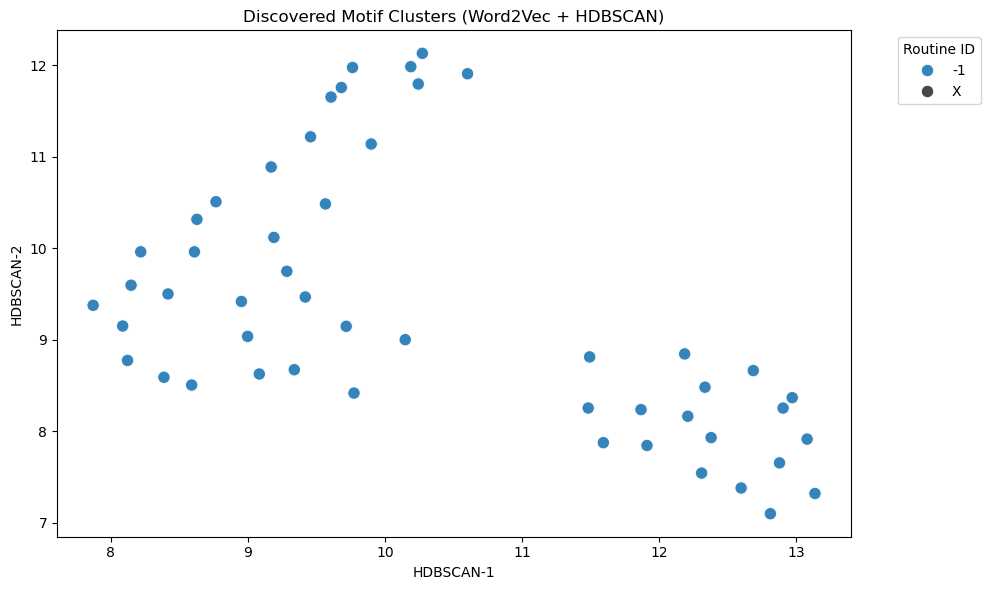

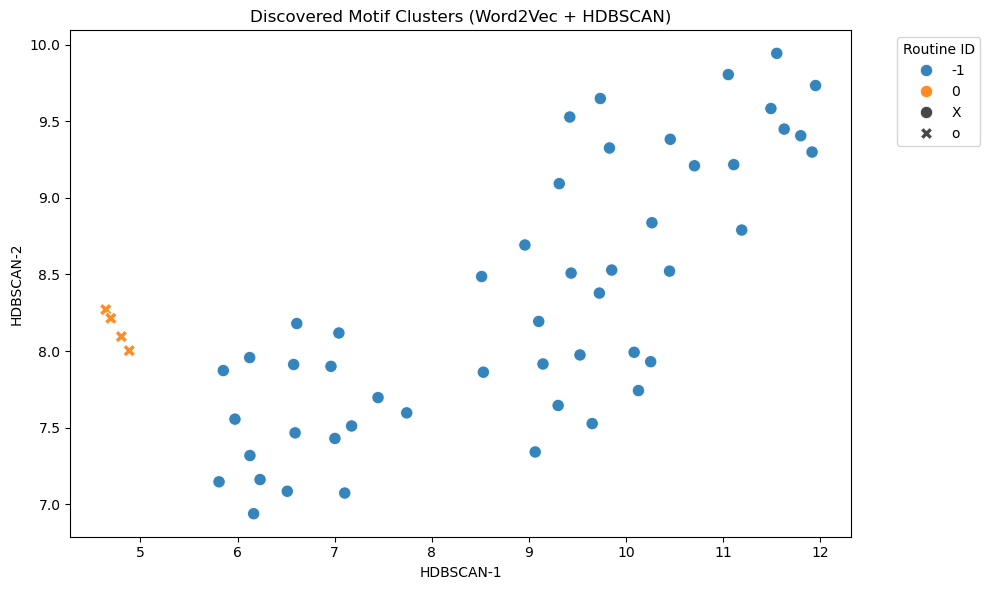

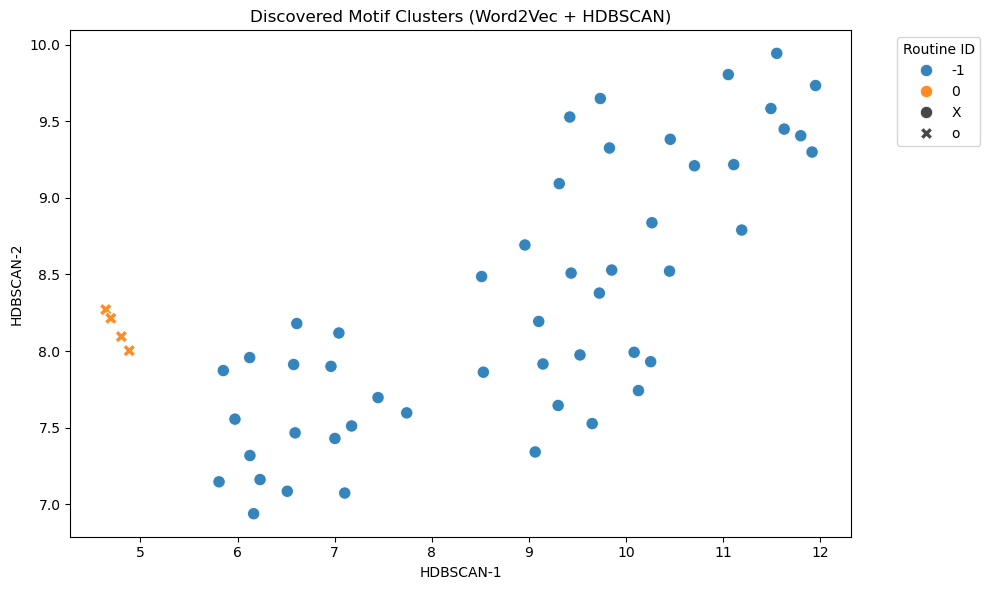

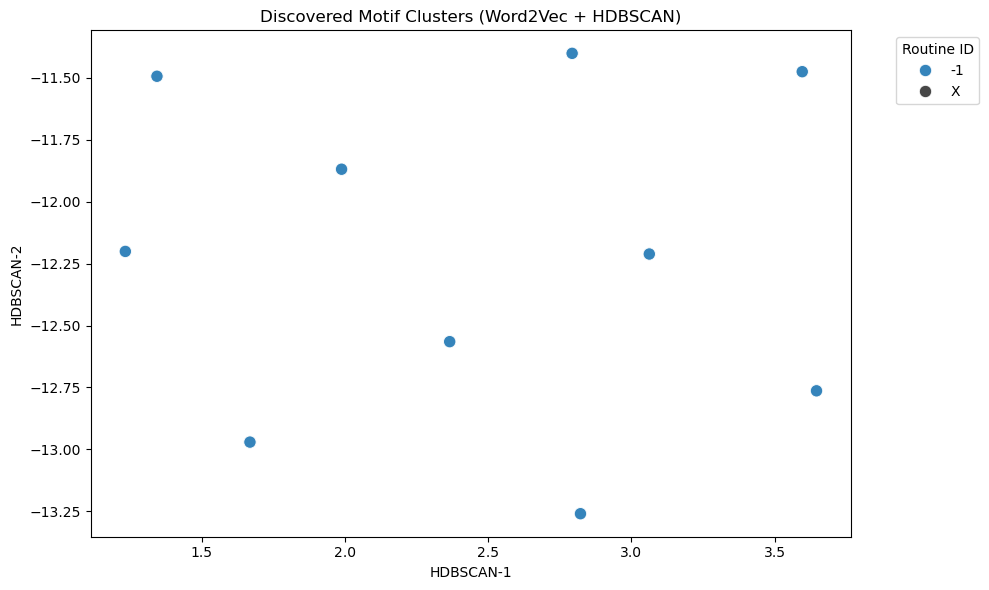

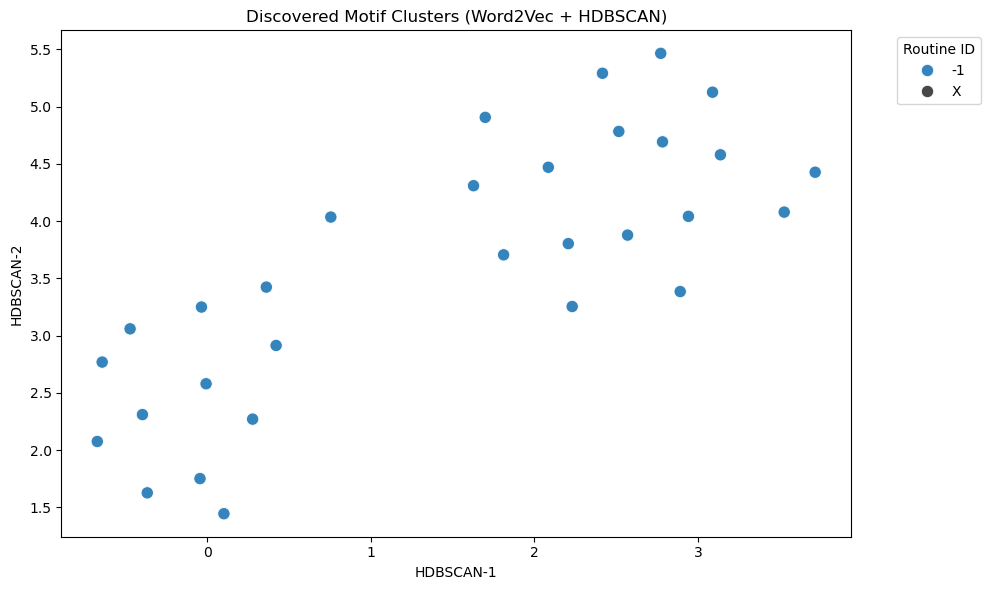

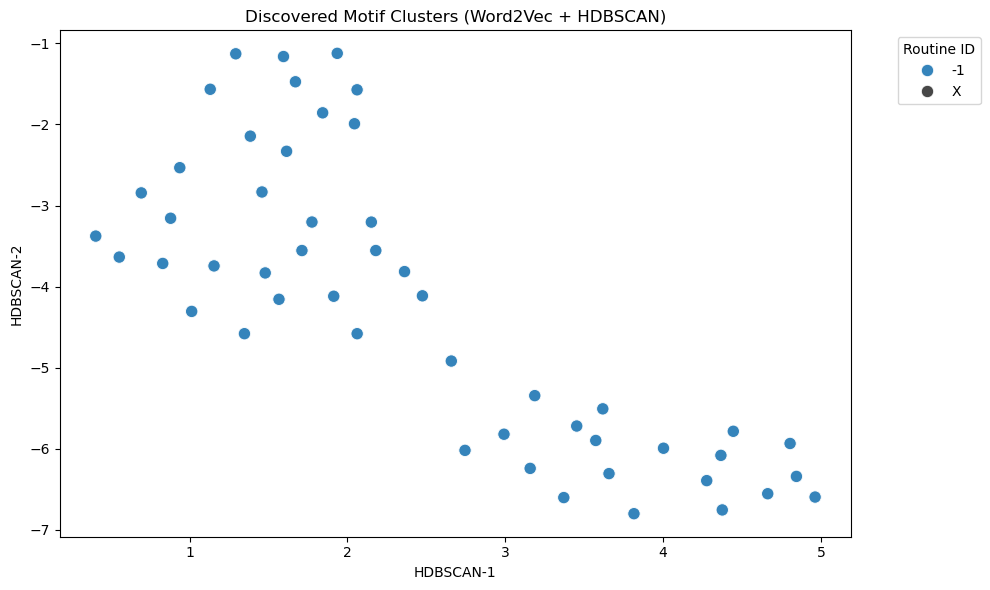

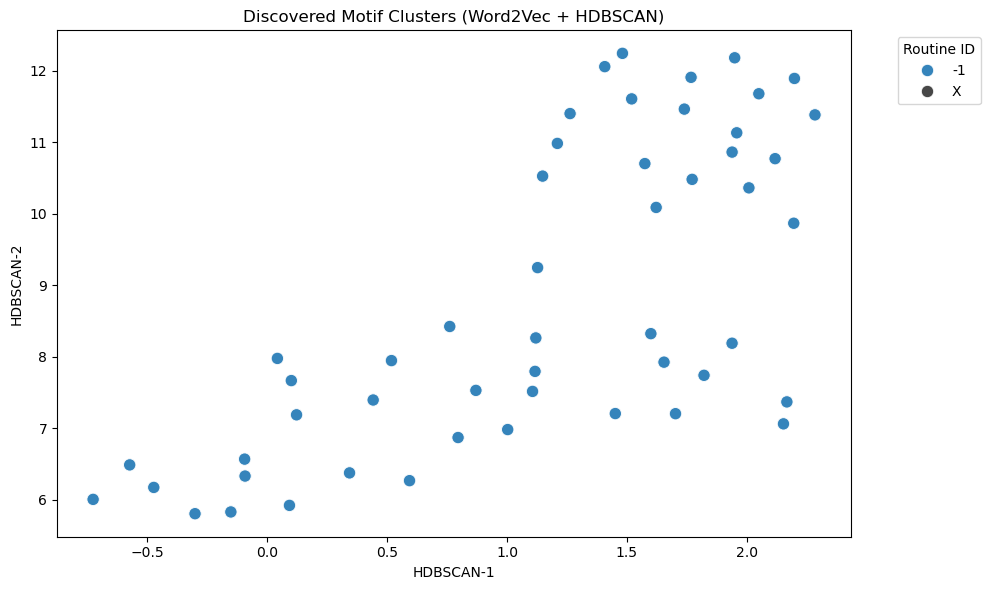

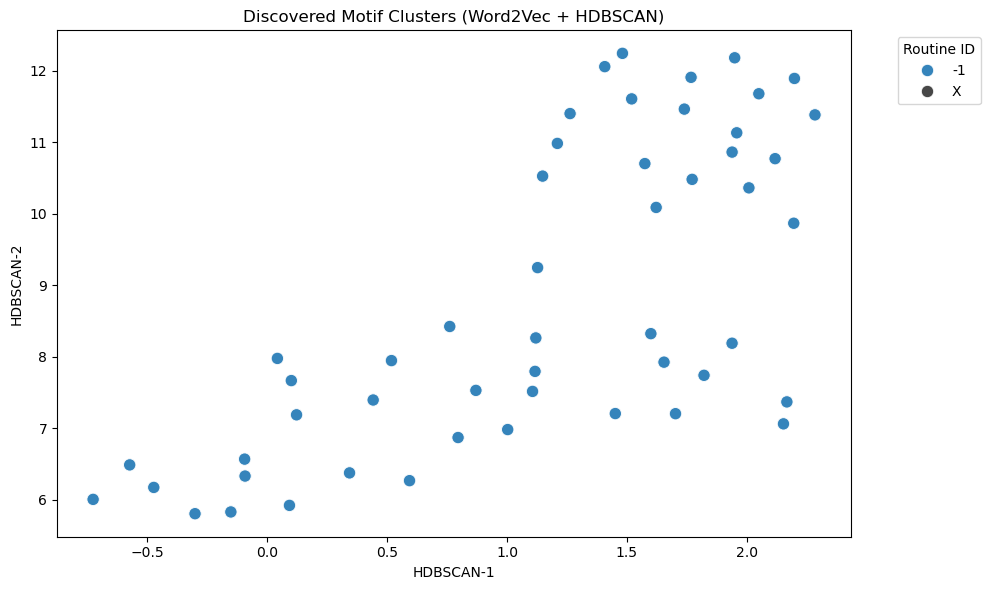

In [3]:
# ---- Inputs ----
# Select the log to discover motifs from
log_to_discover = srrt_plus_log
log_to_discover_name = "SRRT_Plus"
# OR
# log_to_discover = srrt_parallel_log
# log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
threshold = 0.8

# ---- Experiment Parameters ----
window_sizes = [25, 30, 40, 50, 60, 65]
motif_counts = [10, 30, 50, 70, 100]

# ---- Routine Boundaries ----
short_range = (26, 36)  # SR routines
long_range = (56, 66)   # RT routines

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################

# ---- Label Function ----
def label_from_length(length):
    if short_range[0] <= length <= short_range[1]:
        return "SR"
    elif long_range[0] <= length <= long_range[1]:
        return "RT"
    else:
        return "Other"  # Noise or undefined

# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Create Image Folder ----
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    import os
    image_path = f"ExperimentResult/EX4-ClusterPurity_{log_to_discover_name}_Evaluation_{timestamp}"
    if not os.path.exists(image_path):
        os.makedirs(image_path)

# ---- Loop over configurations ----
for size in window_sizes:
    # STEP 1: Compute Matrix Profile
    time_series_data, p_mult_matrix_profil, i_multi_motif_indexes = util.util.compute_matrix_profile(ui_log_encoded_w2v, size)

    for NumberOfMotifsToDiscover in motif_counts:
        # STEP 2: Discover motifs
        motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.extract_motifs(
            time_series_data, p_mult_matrix_profil, i_multi_motif_indexes, NumberOfMotifsToDiscover
        )

        discovered_set = set(motif_indices[0])

        # STEP 3: Evaluate ground truth overlap
        _, _, overlapDF = util.util.compute_discovery_coverage(case_id_list, discovered_set, size, threshold=threshold)

        # STEP 4: Cluster ALL discovered motifs (not just matched ones)
        df_clusters = util.util.cluster_motifs_with_word2vec(ui_log_encoded_w2v, list(discovered_set), size)

        # STEP 5: Add length label for matched motifs
        length_map = dict(zip(overlapDF["discoveredMotif"], overlapDF["groundTruthLength"]))
        df_clusters["length"] = df_clusters["start_index"].map(length_map)

        # Label motifs by routine type if matched, else 'Unknown'
        df_clusters["label"] = df_clusters["length"].apply(lambda l: label_from_length(l) if pd.notnull(l) else "Unknown")

        # STEP 6: Evaluate cluster purity
        N = len(df_clusters)
        purity_total = 0
        for _, group in df_clusters.groupby("routine_id"):
            label_counts = group["label"].value_counts()
            dominant_count = label_counts.max() if not label_counts.empty else 0
            purity_total += dominant_count

        cluster_purity = purity_total / N if N > 0 else 0

        experiment_index_value = str(size) + "_" + str(NumberOfMotifsToDiscover)
        # STEP 7: Store results
        results.append({
            "experiment_index": experiment_index_value,
            "window_size": size,
            "to_discover_motif_count": NumberOfMotifsToDiscover,
            "num_clusters": df_clusters["routine_id"].nunique(),
            "discovered_total_motifs": N,
            "cluster_purity": round(cluster_purity, 3)
        })

        print(f"Window Size: {size}, Motif Count: {NumberOfMotifsToDiscover}, Clusters: {df_clusters['routine_id'].nunique()}, Total Motifs: {N}, Cluster Purity: {round(cluster_purity, 3)}")
        fig = util.util.plot_motif_clusters(df_clusters)
        if save_experiment_to_folder:
            fig.savefig(image_path + "/" + experiment_index_value + ".png")  # Optionally save

# ---- Save the results ----
df_results = pd.DataFrame(results)

if save_experiment_to_folder:
    df_results.to_csv(f"ExperimentResult/EX4-ClusterPurity_{log_to_discover_name}_Evaluation_{timestamp}.csv", index=False)

# 4. Archive

Old encoding method. Improved after reviewer feedback and experiment results in the notebook above.

## 4.1. Hot Encoding Method(s)

Based on the context columns the discovery will be executed

In [ ]:
log_to_discover = srrt_plus_log
#log_to_discover = srrt_parallel_log

# ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id"] # Leno Attributes
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 25
NumberOfMotifsToDiscover = 25

# ---- Generating Ground Truth ----
groundTruth = util.util.generate_caseid_list(log_to_discover)

# ---- Reading the File ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])
uiLog_Encoding_method = 3 # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

uiLog = util.util.encoding_UiLog(log_to_discover,orderedColumnsList=ContextColumns,encoding=uiLog_Encoding_method)

# ---- Time Series Mining ----
tm_matrix, event_series = util.util.discover_motifs(uiLog, window_size=size, normalize=True)

print(f"event_series shape: {event_series.shape}")
print(f"tm_matrix shape: {tm_matrix.shape}")
print(f"tm_matrix[:,0] shape: {tm_matrix[:,0].shape}")

# The motifs have to be exclusive, thus, no one activity must be part of a routine already discovered
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover, cutoff=5)
# Identify the outlier
discord_idx = np.argsort(tm_matrix[:, 0])[-1]
print(f"Discovered: {np.sort(top_motifs[1][0])}")

event_series shape: (9594,)
tm_matrix shape: (9570, 4)
tm_matrix[:,0] shape: (9570,)
Discovered: [   6   32  110  136  189  215  270  296  351  377  432  458  511  537
  593  673  699  754  780  835  861  914  940  995 1021]


## 4.2. Quality Measures

In [ ]:
print(f"Ground Truth:{np.sort(groundTruth)}")

# For 1-dim time series
insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(top_motifs[1][0]), (size/2))

ground_truth_sum = len(groundTruth)
true_positives = len(insert_spots)
false_positives = NumberOfMotifsToDiscover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

## 4.3. Automated Experiment for multiple window sizes
### A. Hot Encoding Based Multi Window Experiment

The following code tests multiple window sizes againts the encoding method and number of motifs to be discovered and visualizes the F1-Score trend afterwards.

In [ ]:
# ---- Inputs ----
log_to_discover = srrt_plus_log
# log_to_discover = srrt_parallel_log

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]
ContextColumns = ['eventType', 'targetApp', 'target.tagName', 'target.name']


NumberOfMotifsToDiscover = 10
uiLog_Encoding_method = 3  # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

uiLog = util.util.encoding_UiLog(log_to_discover, orderedColumnsList=ContextColumns, encoding=uiLog_Encoding_method)


groundTruth = util.util.generate_caseid_list(log_to_discover)
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
for size in range(25, 66):
    uiLog = util.util.encoding_UiLog(log_to_discover, orderedColumnsList=ContextColumns, encoding=uiLog_Encoding_method)
    tm_matrix, event_series = util.util.discover_motifs(uiLog, window_size=size, normalize=True)
    
    config.STUMPY_EXCL_ZONE_DENOM = 1
    top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:, 0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover, cutoff=5)
    
    discovered_set = set(top_motifs[1][0])
    insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
    # insert_spots, motif_spots, overlapDF = util.util.compare_sets_IoU(groundTruth_set, discovered_set, window_size=size, iou_threshold=0.5)

    true_positives = len(insert_spots)
    false_positives = NumberOfMotifsToDiscover - true_positives
    false_negatives = ground_truth_sum - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'window_size': size,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

    # print("Execution completed for window size:" + str(size))

# ---- Save the results ----
results_df = pd.DataFrame(results)
results_df.to_csv('motif_discovery_window_size_experiment.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2)

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# ---- DFG Mining ----
caseuiLog = util.util.reduceLogToDiscovered(uiLog,top_motifs[1][0],size)
end_time = time.time()

cols = ["targetApp","eventType"]
caseuiLog["concept:name"] = caseuiLog[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
caseuiLog["time:timestamp"] = caseuiLog["timeStamp"]
caseuiLog['case:concept:name'] = caseuiLog['case:concept:name'].astype('int64')
pm4pyDf = pm4py.format_dataframe(caseuiLog)
uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
pm4py.view_dfg(uiLogDFG, start_activities, end_activities)

# ---- Motif Visualisation ----
starting_row = 0
ending_row = len(uiLog)-1
ids = uiLog.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(uiLog.loc[starting_row:ending_row,'tuple:id']))]

#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Routine) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
# Plot Matrix profiles
axs2[2].set_xlabel('Activity', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    #axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()